In [1]:
import os
import datetime
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import darts

### Importing data

In [2]:
df = pd.read_csv('data/clean_data.csv')
# df = pd.read_csv('data/clean_data1990.csv') # For data further back
df = (df
        .drop('Unnamed: 0',axis=1)
        .assign(obs=lambda x: list(x.index))
        .set_index(pd.to_datetime(df.Date)))
        
# df = df[(df.index.year >= 2012)&(df.index.year <= 2019)]
df = df[df.index.year>=2010]

In [3]:
def get_errors(test,preds):
    test, preds = np.array(test), np.array(preds)
    diff = preds - test
    mae = np.mean(abs(diff))
    mse = np.mean(diff**2)
    mape = np.mean(abs(diff)/test)
    
    # class err_obj:
    #     def __init__(self,*):
    error_df = pd.DataFrame({'Metric':['MAE','MSE','MAPE'],'Value':[mae,mse,mape]})

    return error_df


### Cleaning & Feature Engineering

In [4]:
features = pd.read_excel('data/Features.xlsx')
features = features.drop('HYcdx5y',axis=1)
features = features.dropna().iloc[::-1]

features.index = pd.to_datetime(features.Date)
dates = features.index.strftime('%Y-%m-01')
features['Date'] = dates
features.index = pd.to_datetime(dates)
features.rename({'Date':'feature_date'},axis=1,inplace=True)

features['2s10s'] = features.yield10y-features.yield2y
features['5s30s'] = features.yield30y-features.yield5y
features['VIXchg'] =  features.VIX.pct_change()
features['U3_lag12'] = features.U3rate.shift(12)
features['fedfunds_lag12'] = features.fedfunds.shift(12)
features['5s30s_lag12'] = features['5s30s'].shift(12)
features['yield2y_lag12'] = features.yield2y.shift(12)


features = features.shift(1).dropna().sort_index()

In [5]:
monthly_df = pd.DataFrame(df.groupby(df.index.strftime('%y/%m')).default.sum())
monthly_df['Date'] = monthly_df.index
monthly_df.index = monthly_df.Date.apply(datetime.datetime.strptime,args=('%y/%m',))
monthly_df['obs'] = range(1,monthly_df.shape[0]+1)
monthly_df['month'] = monthly_df.index.month

In [6]:
monthly_df['lag1'] = monthly_df.default.shift(1)
# monthly_df['inst_trend'] = monthly_df.lag1.values - monthly_df.default.shift(2).values 

# monthly_df['lag2'] = monthly_df.default.shift(2)
# monthly_df['lag12'] = monthly_df.default.shift(12)
# monthly_df['ma12'] = monthly_df.default.rolling(12).mean()

model_df = pd.merge(monthly_df.dropna(),features,left_index=True,right_index=True)
model_df['const'] = 1
del model_df['Date']

### Visualization / Investigation

##### Trend & Seasonality

In [7]:
model = sm.OLS(model_df.default,model_df[['const','obs']]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.07549
Date:                Mon, 04 Apr 2022   Prob (F-statistic):              0.784
Time:                        17:03:32   Log-Likelihood:                -596.65
No. Observations:                 144   AIC:                             1197.
Df Residuals:                     142   BIC:                             1203.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.4758      2.599     11.725      0.000      25.337      35.614
obs           -0.0085      0.031     -0.275      0.784      -0.069       0.052
==============================================================================
Omnibus:                       42.980   Durbin-Watson:                   0.557
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.184
Skew:                           1.393   Prob(JB):                     1.05e-17
Kurtosis:                       5.296   Cond. No.                         172.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

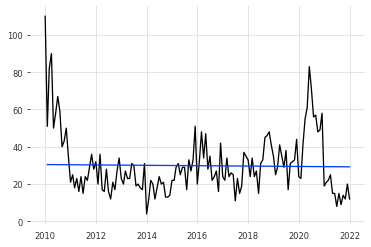

In [8]:
plt.plot(monthly_df.index,monthly_df.default)
plt.plot(model_df.index,model.predict(model_df[['const','obs']]))

Text(0.5, 1.0, 'Defaults by Month (Orange is the mean)')

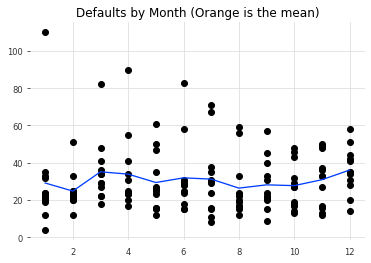

In [9]:
seasonal = monthly_df.groupby('month').default.mean()
plt.plot(monthly_df.month,monthly_df.default,'o')
plt.plot(range(1,13),seasonal.values)
plt.title('Defaults by Month (Orange is the mean)')

##### Correlations

In [10]:
pd.DataFrame({"Month":list(range(13)),"PACF":tsa.pacf(monthly_df.default,12)})

,Month,PACF
0,0,1.000000
1,1,0.643454
2,2,0.338899
3,3,0.181052
4,4,-0.208975
5,5,-0.035614
6,6,0.002768
7,7,-0.034345
8,8,-0.125095
9,9,-0.087796


In [11]:
model_df.corr().default.sort_values(ascending=False).to_frame()

,default
default,1.000000
lag1,0.700492
yield2y_lag12,0.419979
VIX,0.407887
fedfunds_lag12,0.395767
bbb10yspr,0.347739
initialjobless,0.341868
U3rate,0.332132
DXYindex,0.163628
isRec,0.141195


##### Feature Lag Testing

In [12]:
def stylize(styler):
    styler.background_gradient(axis=0, vmin=-1, vmax=1, cmap="coolwarm")
    styler.format(lambda x: round(x,3))
    return styler

In [13]:
lag_cols = ['true_default', 'default',
            'fedfunds', 'yield2y', 'yield10y', 'bbb10yspr',
            'U3rate', 'yield5y', 'yield30y', 'DXYindex', 'VIX',
            'initialjobless', 'isRec', '2s10s', '5s30s']

In [14]:
defaults = model_df.default
lag_corr_df = pd.DataFrame(columns=lag_cols,index=list(range(13)))
lag_corr_df.index.name = 'lag'

for lag in range(19):
    lagged_df = model_df.shift(lag)
    lagged_df.insert(0,'true_default',defaults)
    lagged_df.dropna(inplace=True)

    lag_corr_df.loc[lag,:] = lagged_df[lag_cols].corr().loc['true_default'].values

lag_corr_df = lag_corr_df.apply(pd.to_numeric)

In [15]:
lag_corr_df.style.pipe(stylize)

,true_default,default,fedfunds,yield2y,yield10y,bbb10yspr,U3rate,yield5y,yield30y,DXYindex,VIX,initialjobless,isRec,2s10s,5s30s
lag,,,,,,,,,,,,,,,
0,1.0,1.0,0.077,0.101,-0.013,0.348,0.332,0.031,-0.027,0.164,0.408,0.342,0.141,-0.107,-0.06
1,1.0,0.719,0.111,0.126,-0.023,0.361,0.291,0.05,-0.058,0.185,0.444,0.385,0.222,-0.14,-0.114
2,1.0,0.63,0.172,0.174,-0.03,0.342,0.174,0.08,-0.089,0.226,0.449,0.434,0.349,-0.191,-0.178
3,1.0,0.595,0.248,0.239,-0.028,0.256,0.053,0.126,-0.122,0.277,0.365,0.328,0.42,-0.251,-0.26
4,1.0,0.452,0.295,0.291,0.012,0.18,-0.019,0.184,-0.096,0.285,0.228,0.226,0.306,-0.264,-0.288
5,1.0,0.383,0.339,0.338,0.039,0.14,-0.111,0.238,-0.091,0.307,0.212,0.185,0.25,-0.284,-0.334
6,1.0,0.272,0.397,0.394,0.049,0.039,-0.2,0.277,-0.101,0.318,0.065,0.109,0.224,-0.327,-0.38
7,1.0,0.161,0.456,0.428,0.047,-0.058,-0.302,0.298,-0.119,0.327,-0.052,0.089,0.193,-0.36,-0.419
8,1.0,0.1,0.51,0.455,0.079,-0.095,-0.419,0.339,-0.102,0.342,-0.082,0.019,0.242,-0.356,-0.438


##### Year Dummy Model

In [16]:
dummy_df = pd.get_dummies(model_df.index.year).set_index(model_df.index)
dummy_df1 = pd.merge(model_df,dummy_df,left_index=True,right_index=True)
dummy_cols = list(dummy_df.columns)

for i in dummy_df.columns:
    col = f'{i}*time'
    dummy_df1[f'{i}*time'] = dummy_df[i] * dummy_df1.obs
    dummy_cols.append(col)

In [17]:
model = sm.OLS(dummy_df1.default,dummy_df1[['const','obs']+dummy_cols]).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     12.41
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           2.55e-22
Time:                        17:03:33   Log-Likelihood:                -506.43
No. Observations:                 144   AIC:                             1063.
Df Residuals:                     119   BIC:                             1137.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8630     16.697     -0.531      0.597     -41.924      24.198
obs            0.1759      0.195      0.902      0.369      -0.210       0.562
2010          89.0994     17.755      5.018      0.000      53.942     124.257
2011          15.2675     21.147      0.722      0.472     -26.606      57.141
2012          37.4085     26.959      1.388      0.168     -15.974      90.791
2013          36.8211     33.814      1.089      0.278     -30.134     103.776
2014           7.6055     41.193      0.185      0.854     -73.962      89.173
2015         -52.8188     48.861     -1.081      0.282    -149.568      43.930
2016          88.5041     56.699      1.561      0.121     -23.766     200.774
2017           7.1824     64.647      0.111      0.912    -120.824     135.189
2018        -146.5927     72.667     -2.017      0.046    -290.481      -2.704
2019           2.4458     80.739      0.030      0.976    -157.426     162.318
2020        -222.0472     88.849     -2.499      0.014    -397.976     -46.118
2021         128.2616     96.986      1.322      0.189     -63.780     320.303
2022          -0.0002      0.001     -0.257      0.797      -0.002       0.001
2010*time     -3.5214      0.815     -4.322      0.000      -5.135      -1.908
2011*time      0.7437      0.720      1.032      0.304      -0.683       2.170
2012*time     -0.3577      0.720     -0.497      0.620      -1.783       1.068
2013*time     -0.2808      0.720     -0.390      0.697      -1.706       1.144
2014*time      0.1423      0.719      0.198      0.844      -1.282       1.567
2015*time      1.1877      0.719      1.652      0.101      -0.236       2.611
2016*time     -0.7913      0.719     -1.101      0.273      -2.214       0.632
2017*time      0.1143      0.718      0.159      0.874      -1.308       1.536
2018*time      1.6667      0.718      2.322      0.022       0.245       3.088
2019*time      0.1632      0.718      0.228      0.820      -1.258       1.584
2020*time      2.0619      0.717      2.875      0.005       0.642       3.482
2021*time     -0.9207      0.717     -1.284      0.202      -2.340       0.499
2022*time     -0.0320      0.124     -0.257      0.797      -0.278       0.214
==============================================================================
Omnibus:                        8.813   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               12.777
Skew:                           0.317   Prob(JB):                      0.00168
Kurtosis:                       4.314   Cond. No.                     1.17e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.6e-27. This might indicate 

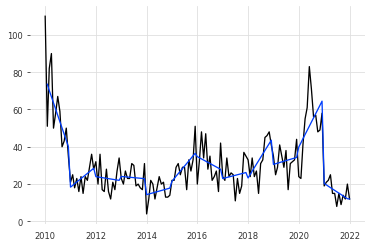

In [18]:
plt.plot(monthly_df.index,monthly_df.default)
plt.plot(model_df.index,model.predict(dummy_df1[['const','obs']+dummy_cols]))

### Linear Model

- Level of outstanding debt in the economy
- Average leverage ratios
- Lags of features

In [19]:
# Train/Test splitting
n = 18
length = model_df.default.count()

train_df = model_df.head(length-n)
test_df = model_df.tail(n)

In [20]:
model_df.columns

Index(['default', 'obs', 'month', 'lag1', 'feature_date', 'fedfunds',
       'yield2y', 'yield10y', 'bbb10yspr', 'IGcdx5y', 'U3rate', 'yield5y',
       'yield30y', 'DXYindex', 'VIX', 'initialjobless', 'isRec', '2s10s',
       '5s30s', 'VIXchg', 'U3_lag12', 'fedfunds_lag12', '5s30s_lag12',
       'yield2y_lag12', 'const'],
      dtype='object')

In [21]:
cols = ['const','lag1','2s10s','U3rate','isRec','bbb10yspr','fedfunds_lag12']
# cols = ['const','lag1','lag2','lag12']


In [22]:
model = sm.OLS(train_df.default,train_df[cols]).fit()
# model = sm.OLS(train_df.default,train_df[cols]).fit_regularized(alpha=1,refit=True,L1_wt=0.1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.513
Method:                 Least Squares   F-statistic:                     22.95
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           7.52e-18
Time:                        17:03:33   Log-Likelihood:                -470.15
No. Observations:                 126   AIC:                             954.3
Df Residuals:                     119   BIC:                             974.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1806      6.250      0.029      0.977     -12.194      12.555
lag1               0.5005      0.067      7.457      0.000       0.368       0.633
2s10s             -3.1627      2.453     -1.289      0.200      -8.019       1.694
U3rate             1.3792      0.783      1.762      0.081      -0.171       2.929
isRec              9.6344      8.926      1.079      0.283      -8.040      27.309
bbb10yspr          4.9434      4.038      1.224      0.223      -3.052      12.939
fedfunds_lag12     3.0473      2.513      1.213      0.228      -1.929       8.023
==============================================================================
Omnibus:                       17.740   Durbin-Watson:                   2.199
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.504
Skew:                           0.724   Prob(JB):                     2.90e-06
Kurtosis:                       4.662   Cond. No.                         379.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

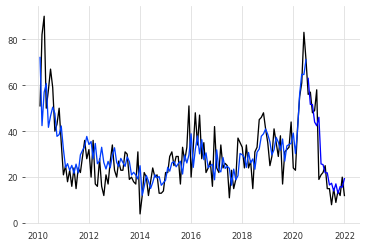

In [23]:
plt.plot(model_df.index,model_df.default)

# plt.plot(model_df.index,model.predict(model_df[cols]))
plt.plot(train_df.index,model.predict(train_df[cols]))
plt.plot(test_df.index,model.predict(test_df[cols]),color='blue')

# plt.plot(model_df.index[:length-n], model.resid.abs())
# model.resid.abs().mean() # MAE


In [24]:
SSR = sum((model.predict(train_df[cols]) - train_df.default)**2)
SAR = sum((model.predict(train_df[cols]) - train_df.default).abs())
SSR, SAR

(12849.359642354639, 954.6725141953972)

In [25]:
get_errors(train_df.default.values,model.predict(train_df[cols]))

,Metric,Value
0,MAE,7.576766
1,MSE,101.979045
2,MAPE,0.316253


### Principle Component Regression

In [26]:
from statsmodels.multivariate.pca import PCA

pca_df = model_df.drop(['default','feature_date','const'],axis=1)
pc = PCA(pca_df,6)
factors = sm.add_constant(pc.factors)
pc_model = sm.OLS(model_df.default,\
                  factors).fit()
pc_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     30.07
Date:                Mon, 04 Apr 2022   Prob (F-statistic):           8.14e-23
Time:                        17:03:34   Log-Likelihood:                -536.19
No. Observations:                 144   AIC:                             1086.
Df Residuals:                     137   BIC:                             1107.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.8542      0.856     34.874      0.000      28.161      31.547
comp_0        24.6250     10.273      2.397      0.018       4.311      44.939
comp_1       -31.8463     10.273     -3.100      0.002     -52.160     -11.533
comp_2      -113.0056     10.273    -11.001      0.000    -133.319     -92.692
comp_3        53.0619     10.273      5.165      0.000      32.748      73.376
comp_4        -1.0791     10.273     -0.105      0.916     -21.393      19.235
comp_5        42.8116     10.273      4.167      0.000      22.498      63.125
==============================================================================
Omnibus:                       24.828   Durbin-Watson:                   1.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.648
Skew:                           0.834   Prob(JB):                     9.04e-10
Kurtosis:                       5.040   Cond. No.                         12.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

7.632621028532891

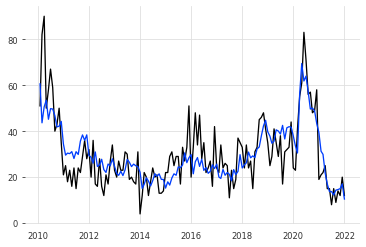

In [27]:
plt.plot(model_df.index,model_df.default)
plt.plot(model_df.index,pc_model.predict(factors))
pc_model.resid.abs().mean() # MAE

### KNN Model

In [28]:
reg = KNeighborsRegressor(5)
neighbor = reg.fit(model_df[cols],model_df.default)

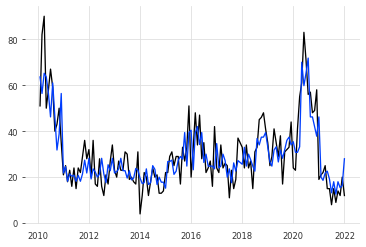

In [29]:
plt.plot(model_df.index,model_df.default)
plt.plot(model_df.index,neighbor.predict(model_df[cols]))


### Random Forest

In [30]:
forest = RandomForestRegressor(n_estimators=int(len(feats)**0.5),max_depth=5).fit(train_df[feats],train_df.default)

NameError: name 'feats' is not defined

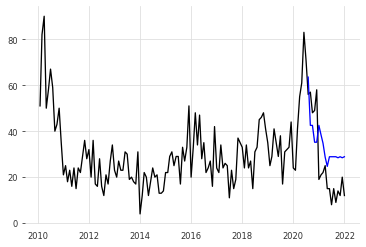

In [ ]:
plt.plot(model_df.index,model_df.default)
# plt.plot(train_df.index,forest.predict(train_df[feats]))

plt.plot(test_df.index,forest.predict(test_df[feats]),color='Blue')

##### Gradient Boosting

In [ ]:
grad = GradientBoostingRegressor().fit(model_df[feats],model_df.default)

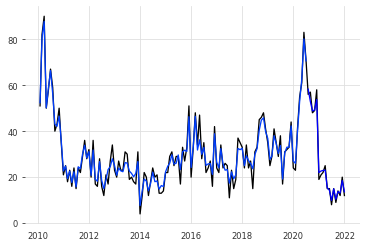

In [ ]:
plt.plot(model_df.index,model_df.default)
plt.plot(train_df.index,grad.predict(train_df[feats]))

plt.plot(test_df.index,grad.predict(test_df[feats]),color='Blue')

### Holt-Winters Model

''

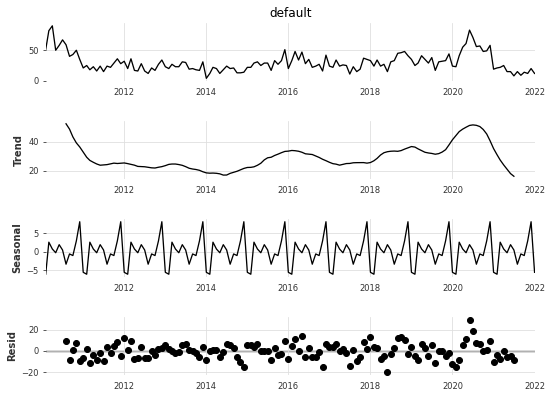

In [ ]:
decomp = tsa.seasonal_decompose(model_df.default)
fig = decomp.plot()
fig.set_figheight(6)
fig.set_figwidth(8)
;

In [32]:
train_end_dt = pd.to_datetime('08-01-2021')
es = tsa.ExponentialSmoothing(model_df[:train_end_dt].default,seasonal='mul',trend='add').fit()
# es.summary()

/Users/landon/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


''

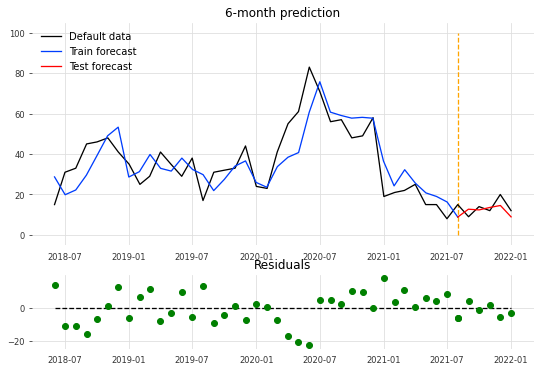

In [33]:
start_date = pd.to_datetime('06-01-2018')
last_date = pd.to_datetime('01-01-2022')

preds = (es.predict(start_date,train_end_dt),es.predict(train_end_dt,last_date))
fig, ax = plt.subplots(2,1,figsize=(9,6),gridspec_kw={'height_ratios': [3, 1]})

ax[0].set_title(f'{len(preds[1])}-month prediction')
ax[0].plot(model_df[start_date:last_date].index,model_df[start_date:last_date].default,label='Default data')
ax[0].plot(pd.date_range(start_date,train_end_dt,periods=len(preds[0])),preds[0],label='Train forecast')
ax[0].plot(pd.date_range(train_end_dt,last_date,periods=len(preds[1])),preds[1],color='red',label='Test forecast')
ax[0].vlines(train_end_dt,0,100,linestyles='dashed',color='orange')
ax[0].legend()
ax[0].legend(loc='upper left')

ax[1].set_title('Residuals')
ax[1].plot(model_df[start_date:train_end_dt].index,preds[0]-model_df[start_date:train_end_dt].default,'o',color='green')
ax[1].plot(model_df[train_end_dt:last_date].index,preds[1]-model_df[train_end_dt:last_date].default,'o',color='green')
ax[1].hlines(0,start_date,last_date,linestyles='dashed')
;

In [35]:
resid_df = pd.concat((model_df.default,preds[1]),1,'inner')

/Users/landon/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  """Entry point for launching an IPython kernel.


In [140]:
get_errors(resid_df.default,resid_df[0])

,Metric,Value
0,MAE,3.598839
1,MSE,15.988479
2,MAPE,0.266524


### Darts Models

In [144]:
from darts.utils.statistics import plot_acf
import darts.models
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
# from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta

In [148]:
scaler = MinMaxScaler()
transform = Scaler(scaler)

In [149]:
rel_cols = ['lag1',
            '2s10s',
            'U3rate',
            'isRec',
            'bbb10yspr',
            'fedfunds_lag12',
            'fedfunds',
            'VIX',
            'DXYindex',
            'initialjobless',
            # 'yield2y',
            # 'yield10y',
            'default']

In [150]:
ts_df = (model_df
            [rel_cols]
            .reset_index())
            
series = darts.TimeSeries.from_dataframe(ts_df,'Date')
series = transform.fit_transform(series)
train, val = series.split_before(0.9)

cov = series[[i for i in rel_cols if i is not 'default']]

In [151]:
X = train[[i for i in rel_cols if i is not 'default']]
y = train['default']

valX = val[[i for i in rel_cols if i is not 'default']]
valy = val['default']

In [152]:
# model = darts.models.AutoARIMA()
# model = darts.models.ExponentialSmoothing()
# model = darts.models.NBEATSModel(len(valy),12)
model = darts.models.RNNModel(18,'RNN')

In [167]:
# model.fit([train[i] for i in rel_cols],epochs=50)
# model.fit(y,future_covariates=X)
model.fit(y,future_covariates=cov,
            # val_series=valy,
            # val_future_covariates=cov,
            epochs=1000)

[2022-03-30 17:03:03,979] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 104 samples.
[2022-03-30 17:03:03,979] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 104 samples.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
[2022-03-30 17:03:03,989] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a checkpoint. This is currently discouraged. Consider setting `save_checkpoints` to `True` and specifying `model_name` at model creation. Then call `model = RNNModel.load_from_checkpoint(model_name, best=False)`. Finally, train the model with `model.fit(..., epochs=new_epochs)` where `new_epochs` is the sum of (epochs already trained + some additional epochs).
[2022-03-30 17:03:03,989] WARNING | darts.models.forecasting.torch_forecasting_model | Attempting to retrain the model without resuming from a ch

Epoch 50:  50%|█████     | 2/4 [00:00<00:00, 31.71it/s, loss=0.00501, train_loss=0.00572]

/Users/landon/miniconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [168]:
# pred = model.predict(2,train['default'])
pred = model.predict(16,future_covariates=cov)
pred

Predicting: 2it [00:00, ?it/s]
Epoch 64:  25%|██▌       | 1/4 [00:29<01:29, 29.81s/it, loss=0.00607, train_loss=0.00625]


<TimeSeries (DataArray) (Date: 16, component: 1, sample: 1)>
array([[[0.23983763]],

       [[0.05714807]],

       [[0.04449467]],

       [[0.20759376]],

       [[0.32240671]],

       [[0.25994343]],

       [[0.21766605]],

       [[0.15005369]],

       [[0.06465335]],

       [[0.10718989]],

       [[0.1144323 ]],

       [[0.19262078]],

       [[0.2930642 ]],

       [[0.27711353]],

       [[0.26447799]],

       [[0.20569578]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2020-10-01 2020-11-01 ... 2022-01-01
  * component  (component) object 'default'
Dimensions without coordinates: sample

In [169]:
darts.metrics.mae(valy,pred)

0.1501495495469246

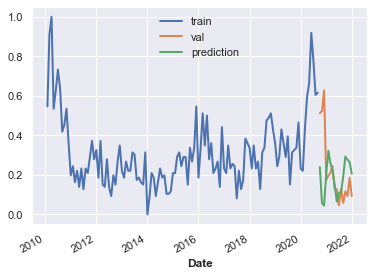

Epoch 50:  50%|█████     | 2/4 [00:10<00:10,  5.15s/it, loss=0.00501, train_loss=0.00572]

In [170]:
y.plot(label='train')
valy.plot(label='val')
pred.plot(label='prediction')


### Tensorflow Models

#### Data Cleaning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, minmax_scale

In [ ]:
# train_df = model_df.sample(frac=0.8)
# test_df = model_df.drop(train_df.index)

# factors['default'] = model_df.default
# train_df = factors.sample(frac=0.8)
# test_df = factors.drop(train_df.index)

In [485]:
X = model_df[rel_cols].values
y = model_df.default.values

In [486]:
train_target = train_df.default.values
train_feature_tensor = tf.convert_to_tensor(train_df[rel_cols])
# train_feature_tensor = tf.convert_to_tensor(train_df.drop('default',axis=1))


test_target = test_df.default.values
test_feature_tensor = tf.convert_to_tensor(test_df[rel_cols])
# test_feature_tensor = tf.convert_to_tensor(test_df.drop('default',axis=1))

In [ ]:
# normalizer = tf.keras.layers.Normalization(axis=-1)
# normalizer.adapt(train_df[cols])
# normalizer.adapt(train_df.drop(['default','feature_date'],axis=1))
ts_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    X,
    y,
    12,
    sampling_rate=2,
    stride=1,
    start_index=0,
    end_index=None,
    shuffle=False,
    reverse=False,
    batch_size=128
)


#### Model Building

In [503]:
net = tf.keras.models.Sequential([
    # normalizer,
    # tf.keras.layers.Flatten(input_shape=(len(cols),)),
    # tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)])

net.compile(optimizer='adam',
            loss=tf.losses.MeanSquaredError())
# metrics=['loss']

In [504]:
net.fit(train_feature_tensor, train_target, epochs=512, batch_size=16)
# ,verbose=False
# net.fit(ts_gen,epochs=100)

Epoch 1/512
8/8 [==============================] - 1s 3ms/step - loss: 733.0969
Epoch 2/512
8/8 [==============================] - 0s 13ms/step - loss: 310.4293
Epoch 3/512
8/8 [==============================] - 0s 6ms/step - loss: 189.0616
Epoch 4/512
8/8 [==============================] - 0s 5ms/step - loss: 188.3220
Epoch 5/512
8/8 [==============================] - 0s 3ms/step - loss: 186.4198
Epoch 6/512
8/8 [==============================] - 0s 3ms/step - loss: 179.6706
Epoch 7/512
8/8 [==============================] - 0s 3ms/step - loss: 150.7319
Epoch 8/512
8/8 [==============================] - 0s 4ms/step - loss: 142.6225
Epoch 9/512
8/8 [==============================] - 0s 3ms/step - loss: 166.6941
Epoch 10/512
8/8 [==============================] - 0s 3ms/step - loss: 125.5160
Epoch 11/512
8/8 [==============================] - 0s 3ms/step - loss: 169.2728
Epoch 12/512
8/8 [==============================] - 0s 3ms/step - loss: 160.9275
Epoch 13/512
8/8 [==================

In [508]:
preds = net.predict(test_feature_tensor)
# list(ts_gen)[0][0][:,:,-12:]
# preds = net.predict(list(ts_gen)[0][0][-12:,:,:])[:,0]

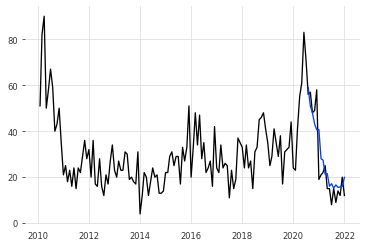

In [509]:
plt.plot(model_df.index,model_df.default)
plt.plot(model_df.iloc[-18:].index,preds)

# plt.plot(model_df.iloc[-16:-4].index,preds,'-')

In [523]:
get_errors(test_df.default,preds)

,Metric,Value
0,MAE,17.511602
1,MSE,511.357371
2,MAPE,0.908236


### Best Subset Selection

In [ ]:
import itertools
import time
from IPython.display import clear_output

In [ ]:
class BESS:

    models_best = pd.DataFrame(columns=["RSS", "model"])
    nmodels = 0

    def __init__(self,X,y,features: list,nvmax = 2,test_y=None,test_X=None):
        self.X = X
        self.y = y
        self.features = features
        self.nvmax = nvmax
        self.test_y = test_y
        self.test_X = test_X
        self.total_models = sum([len(list(itertools.combinations(self.X[self.features].columns, k))) for k in range(1,self.nvmax+1)])


    def processSubset(self,feature_set,):
        feature_set = list(feature_set)
        X = self.X[feature_set]
        model = sm.OLS(self.y,X)
        regr = model.fit()
        
        if type(self.test_y) != type(None) and type(self.test_X) != type(None):
            test_X = self.test_X[feature_set]
            RSS = ((regr.predict(test_X) - self.test_y) ** 2).sum()
        else:
            RSS = ((regr.predict(X) - self.y) ** 2).sum()
        
        self.nmodels += 1
        clear_output(wait=True)
        print(f'{self.nmodels} / {self.total_models} models analyzed', end='', flush=True)
        
        return {"model":regr, "RSS":RSS}

    def getBest(self,k):
        results = []
        
        for combo in itertools.combinations(self.X[self.features].columns, k):
            results.append(self.processSubset(combo))
        
        models = pd.DataFrame(results)
        best_model = models.loc[models.RSS.argmin()]
        
        
        return best_model

    def search(self):
        self.models_best = pd.DataFrame(columns=["RSS", "model"])

        for i in range(1,self.nvmax+1):
            self.models_best.loc[i] = self.getBest(i)

        self.models_best["R_sq"] = self.models_best.model.apply(lambda x: x.rsquared)
        self.models_best["adj_R_sq"] = self.models_best.model.apply(lambda x: x.rsquared_adj)

        return self.models_best

In [ ]:
feats = ['const',
         'lag1',
         'bbb10yspr'
         ,'2s10s',
         'U3rate',
         'isRec',
         'fedfunds',
         'obs',
         'VIX',
         'DXYindex',
        #  '5s30s',
        #  'yield2y',
        #  'yield10y',
         'fedfunds_lag12',
         'U3_lag12',
         '5s30s_lag12'
         ]

In [ ]:
# ,test_X=test_df,test_y=test_df.default
best = BESS(train_df,train_df.default,features=feats,test_X=test_df,test_y=test_df.default,nvmax=8)
models = best.search()
models

7098 / 7098 models analyzed

,RSS,model,R_sq,adj_R_sq
1,1854.920600,<statsmodels.regression.linear_model.Regressio...,0.870592,0.869557
2,1589.988459,<statsmodels.regression.linear_model.Regressio...,0.798081,0.794824
3,1327.300488,<statsmodels.regression.linear_model.Regressio...,0.907467,0.905210
4,1126.590077,<statsmodels.regression.linear_model.Regressio...,0.897828,0.894478
5,1130.916786,<statsmodels.regression.linear_model.Regressio...,0.897934,0.893716
6,1135.575909,<statsmodels.regression.linear_model.Regressio...,0.898077,0.892981
7,1145.708520,<statsmodels.regression.linear_model.Regressio...,0.592396,0.571845
8,1113.419307,<statsmodels.regression.linear_model.Regressio...,0.596827,0.572910


In [ ]:
best_model = models.model.iloc[models.RSS.argmin()]
best_feats = list(best_model.params.index)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                default   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.573
Method:                 Least Squares   F-statistic:                     24.95
Date:                Sat, 26 Mar 2022   Prob (F-statistic):           1.30e-20
Time:                        22:04:03   Log-Likelihood:                -461.35
No. Observations:                 126   AIC:                             938.7
Df Residuals:                     118   BIC:                             961.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -42.3922     22.976     -1.845      0.068     -87.891       3.106
lag1               0.3003      0.077      3.876      0.000       0.147       0.454
bbb10yspr          4.3260      3.799      1.139      0.257      -3.197      11.849
U3rate             2.6210      0.755      3.471      0.001       1.126       4.116
obs               -0.1451      0.094     -1.549      0.124      -0.331       0.040
DXYindex           0.6850      0.272      2.522      0.013       0.147       1.223
fedfunds_lag12     3.1026      3.163      0.981      0.329      -3.160       9.365
5s30s_lag12       -8.5577      3.731     -2.294      0.024     -15.946      -1.169
==============================================================================
Omnibus:                        9.429   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               11.188
Skew:                           0.466   Prob(JB):                      0.00372
Kurtosis:                       4.123   Cond. No.                     3.13e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

7.307253372220067

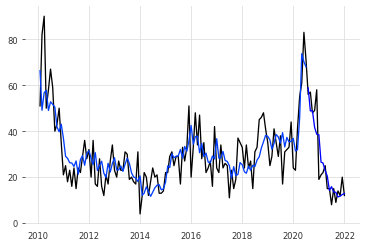

In [ ]:
plt.plot(model_df.index,model_df.default)

# plt.plot(model_df.index,model.predict(model_df[cols]))
plt.plot(train_df.index,best_model.predict(train_df[best_feats]))
plt.plot(test_df.index,best_model.predict(test_df[best_feats]),color='blue')

# plt.gca().twinx().plot(model_df.index,model_df.fedfunds,color='Green')

# plt.plot(model_df.index[:length-n], best_model.resid.abs())
best_model.resid.abs().mean() # MAE

<AxesSubplot:ylabel='Density'>

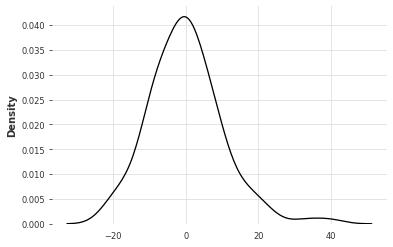

In [ ]:
sns.kdeplot(model.resid)